In [ ]:
# needed libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape, Dropout, BatchNormalization, Activation, LeakyReLU

# utilities
import os
import random
from glob import glob
import matplotlib.pyplot as plt
import pathlib
import time
import datetime

from IPython import display

gpu_available = tf.config.list_physical_devices('GPU')
print(gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
seed = 65
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install pickle5
import pickle5 as pickle

# store processed data in pkl files
def save_pkl_data(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
        print("data stored succesfully to: ", filename)


# read processed data in pkl files
def load_pkl_data(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

     |████████████████████████████████| 256 kB 3.9 MB/s 


In [ ]:
cubes = load_pkl_data('nusc_multiple_agents_inp.pkl') 

# Masking

In [ ]:
def get_look_ahead_mask(input):
  input_shape = list(input.shape)[:-1]
  input_shape.insert(-1, input_shape[-1])
  input_shape.insert(1, 1)
  mask = 1 - tf.linalg.band_part(tf.ones(input_shape), -1, 0)
  return mask

In [ ]:
def adapt_spatial_mask(mask):
  return mask[np.newaxis, : , np.newaxis, : ]         #(1 (head), seq, 1 (neighbor), neighbors) to broadcast when doing addition in the attention layer

In [ ]:
def adapt_seq_mask(mask):
  return mask[np.newaxis, np.newaxis, np.newaxis, : ]   #(1 (head), 1(neighbors), 1(seq), seq)

# Positional Encoding

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(max_position, d_model):
  angle_rads = get_angles(np.arange(max_position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

# Attention

In [ ]:
def ScaledDotProduct(Q, K, V, mask=None):
    dk = tf.cast(tf.shape(K)[-1], tf.float32)

    # compute attention 
    KT = tf.transpose(K, [0, 1, 2, 4, 3])                 
    attention = tf.matmul(Q, KT)/tf.sqrt(dk)

    # mask if necessary
    if mask is not None:
      #print(attention.shape)
      attention += (mask * -1e9)

    # compute values and weighted sum of their attention
    weights = tf.nn.softmax(attention, axis=-1)
    #weights = tf.nn.sigmoid(attention)
    output = tf.matmul(weights, V)

    return output, weights 

In [ ]:
class MultiHeadAttention(keras.layers.Layer):
  def __init__(self, dk=256, num_heads=8):
    super(MultiHeadAttention, self).__init__()
    
    # params
    self.num_heads = num_heads
    self.dk = dk
    self.dk_by_head = dk//num_heads

    # layers
    self.WQ = keras.layers.Dense(dk)
    self.WK = keras.layers.Dense(dk)
    self.WV = keras.layers.Dense(dk)
    self.dense = keras.layers.Dense(dk)
    
  def splitheads(self, x):
    batch_size, seq_length = x.shape[0:2]

    # spliting the heads done by reshaping last dimension
    x = tf.reshape(x, (batch_size, seq_length, -1, self.num_heads, self.dk_by_head))      #(batch, seq, neighbors, head, features_by_head)
    return tf.transpose(x, (0, 3, 1, 2, 4))                                               #(batch, head, seq, neighbors, features_by_head)

  def call(self, q, k, v, mask=None):
    batch_size, seq_length = q.shape[0:2]

    # projections
    q = self.WQ(q)
    k = self.WK(k)
    v = self.WV(v)

    # split heads
    q = self.splitheads(q)
    k = self.splitheads(k)
    v = self.splitheads(v)

    # compute attention and merge heads
    attn_output, attention = ScaledDotProduct(q, k, v, mask)                              #(batch, head, seq, neighbors, features_by_head)
    attn_output = tf.transpose(attn_output,  (0, 2, 3, 1, 4))                             #(batch, seq, neighbors, head, features_by_head)
    concat_output = tf.reshape(attn_output, (batch_size, seq_length, -1, self.dk))        #(batch, seq, neighbors, features)
    output = self.dense(concat_output)

    return output, attention


# Transformer Architecture

In [ ]:
def get_ffn(d_model, hidden_size, act_func='relu'):
  return keras.models.Sequential([
                                  keras.layers.Dense(hidden_size, activation=act_func),
                                  keras.layers.Dense(d_model)
  ], name='SEQ')

In [ ]:
class EncoderLayer(keras.layers.Layer):
  def __init__(self, dk=256, num_heads=8, hidden_layer_size=256, drop_rate=0.1):
    super(EncoderLayer, self).__init__()
    
    # layers
    self.MH = MultiHeadAttention(dk, num_heads)
    #self.ffn = get_ffn(dk, hidden_layer_size)
    self.normLayer1 = keras.layers.LayerNormalization(epsilon=1e-6)
    self.normLayer2 = keras.layers.LayerNormalization(epsilon=1e-6)
    self.dropout1 = keras.layers.Dropout(drop_rate)
    self.dropout2 = keras.layers.Dropout(drop_rate)

  def call(self, x, training, mask):
    # multihead attention
    attn_output, _ = self.MH(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=training)
    z = self.normLayer1(x + attn_output)
    # normalization and feed forward layers
    #output = self.ffn(z)
    #output = self.dropout2(output, training=training)
    #output = self.normLayer2(z + output)

    return z 

In [ ]:
sample_encoder_layer = EncoderLayer()

In [ ]:
samp_inp = tf.random.uniform((3, 20, 6, 256))
out = sample_encoder_layer(samp_inp, True, None)
out.shape

TensorShape([3, 20, 6, 256])

In [ ]:
class DecoderLayer(keras.layers.Layer):
  def __init__(self, dk=256, num_heads=8, hidden_layer=256, drop_rate=0.1):
    super(DecoderLayer, self).__init__()
    # layers
    self.SAMH = MultiHeadAttention(dk, num_heads)
    self.EDMH = MultiHeadAttention(dk, num_heads)
    #self.ffn = get_ffn(dk, hidden_layer)

    self.normLayer1 = keras.layers.LayerNormalization(epsilon=1e-6)
    self.normLayer2 = keras.layers.LayerNormalization(epsilon=1e-6)
    self.normLayer3 = keras.layers.LayerNormalization(epsilon=1e-6)\

    self.dropout1 = keras.layers.Dropout(drop_rate)
    self.dropout2 = keras.layers.Dropout(drop_rate)
    self.dropout3 = keras.layers.Dropout(drop_rate)
  
  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

    # self attention computation
    self_attn_out, self_attn = self.SAMH(x, x, x, look_ahead_mask)
    self_attn_out = self.dropout1(self_attn_out, training=training)
    z = self.normLayer1(x + self_attn_out) 

    # encoder decoder computation
    enc_dec_out, enc_dec_attn = self.EDMH(z, enc_output, enc_output, padding_mask)
    enc_dec_out = self.dropout2(enc_dec_out, training=training)
    z = self.normLayer2(z + enc_dec_out)

    # feed forward computation
    #output = self.ffn(z)
    #output = self.dropout3(output, training=training)
    #output = self.normLayer3(z + output)

    return z, self_attn, enc_dec_attn


In [ ]:
sample_decoder_layer = DecoderLayer()

In [ ]:
dec_inp = tf.random.uniform((3, 20, 6, 256))
out2 = sample_decoder_layer(dec_inp, out, True, None, None)
out2[0].shape

TensorShape([3, 20, 6, 256])

In [ ]:
class Encoder(keras.layers.Layer):
  def __init__(self, features_size, max_size, dk_model=256, num_heads=8, num_encoders=6, 
               enc_hidden_size=256, use_pos_emb=True, drop_rate=0.1):
    super(Encoder, self).__init__()

    # params
    self.dk_model = dk_model
    self.max_size = max_size
    self.use_pos_emb = use_pos_emb
    self.enc_hidden_size = enc_hidden_size
    self.num_encoders = num_encoders
    
    # layers
    #self.embedding = keras.layers.Embedding(features_size, dk_model)
    self.positional_encoding = positional_encoding(self.max_size, self.dk_model)
    self.embedding = keras.layers.Dense(dk_model)
    self.encoders_stack = [EncoderLayer(dk_model, num_heads, enc_hidden_size, drop_rate) for _ in range(num_encoders)]
    self.dropout = tf.keras.layers.Dropout(drop_rate)
  
  def call(self, x, padding_mask, training):
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.dk_model, tf.float32))

    if self.use_pos_emb:
      x += self.positional_encoding
    
    x = self.dropout(x, training=training)
    
    for encoder_layer in self.encoders_stack:
      x = encoder_layer(x, training, padding_mask)
    
    return x

In [ ]:
samp_inp = tf.random.uniform((3, 6, 20, 256))
encoder = Encoder(256, 20, 256)
out = encoder(samp_inp, None, True)
out.shape

HI


TensorShape([3, 6, 20, 256])

In [ ]:
class Decoder(keras.layers.Layer):
  def __init__(self, features_size, max_size, dk_model=256, num_heads=8, num_decoders=6, 
               dec_hidden_size=256, use_pos_emb=True, drop_rate=0.1):
    
    super(Decoder, self).__init__()

    # params
    self.dk_model = dk_model
    self.max_size = max_size
    self.use_pos_emb = use_pos_emb
    self.dec_hidden_size = dec_hidden_size
    self.num_decoders = num_decoders
    self.positional_encoding = positional_encoding(self.max_size, self.dk_model)

    # layers
    self.embedding = keras.layers.Dense(dk_model)
    self.decoders_stack = [DecoderLayer(dk_model, num_heads, dec_hidden_size, drop_rate) for _ in range(num_decoders)]
    self.dropout = tf.keras.layers.Dropout(drop_rate)

  def call(self, x, enc_output, look_ahead_mask, padding_mask, training):
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.dk_model, tf.float32))
    if self.use_pos_emb:
      x += self.positional_encoding
    
    x = self.dropout(x, training=training)
    
    for decoder_layer in self.decoders_stack:
      x, attn1, attn2, = decoder_layer(x, enc_output, training, look_ahead_mask, padding_mask)
    
    return x

In [ ]:
samp_inp = tf.random.uniform((3, 6, 20, 256))
decoder = Decoder(256, 20, 256)
out2 = decoder(samp_inp, out, None, None, True)
out2.shape

HI
xs:  (3, 6, 20, 256)
pe:  (1, 20, 256)
xs:  (3, 6, 20, 256)


TensorShape([3, 6, 20, 256])

In [ ]:
class STTransformer(keras.Model):
  def __init__(self, features_size, max_seq_size, max_neighbors_size, 
               sp_dk=256, sp_enc_heads=8, sp_dec_heads=8, sp_num_encoders=6, sp_num_decoders=6, 
               tm_dk=256, tm_enc_heads=8, tm_dec_heads=8, tm_num_encoders=6, tm_num_decoders=6, 
               dec_hidden_size=256, drop_rate=0.1):
    
    super(STTransformer, self).__init__()

    # layers
    self.sp_encoder = Encoder(features_size, max_neighbors_size, sp_dk, num_heads=sp_enc_heads,  num_encoders=sp_num_encoders, use_pos_emb=False)
    self.sp_decoder = Decoder(features_size, max_neighbors_size, sp_dk, num_heads=sp_dec_heads,  num_decoders=sp_num_decoders, use_pos_emb=False)
    self.tm_encoder = Encoder(features_size, max_seq_size, tm_dk, num_heads=tm_enc_heads,  num_encoders=tm_num_encoders)
    self.tm_decoder = Decoder(features_size, max_seq_size, tm_dk, num_heads=tm_dec_heads,  num_decoders=tm_num_decoders)
    self.linear = tf.keras.layers.Dense(2, name='Linear_Trans')

    
  def call(self, inputs, training):
    inp, inp_masks, seq_inp_masks, targets, tar_masks, seq_tar_masks = inputs
    
    sp_enc_out = self.sp_encoder(inp,  inp_masks, training)                               #(batch, seq, neighbors, <spatial attn features>)
    out = tf.transpose(sp_enc_out, [0, 2, 1, 3])                                          #(batch, neighbors, seq, <spatial attn features>)
    tm_enc_out = self.tm_encoder(out, seq_inp_masks, training)                            #(batch, neighbots, seq, <time attn features>)
    
    # decode time
    targets = tf.transpose(targets, [0, 2, 1, 3])                                         #(batch, neighbors, seq, features)
    look_mask = get_look_ahead_mask(targets)
    tm_dec_out = self.tm_decoder(targets, tm_enc_out, look_mask, seq_tar_masks, training) 
    out2 = tf.transpose(tm_dec_out, [0, 2, 1, 3])                                         #(batch, seq, neighbors, features)
    sp_dec_out = self.sp_decoder(out2, sp_enc_out, None, tar_masks, training)
    
    # linear projection
    output = self.linear(sp_dec_out)
    return output

In [ ]:
# class STTransformer(keras.Model):
#   def __init__(self, features_size, max_seq_size, max_neighbors_size, 
#                sp_dk=256, sp_enc_heads=8, sp_dec_heads=8, sp_num_encoders=6, sp_num_decoders=6, 
#                tm_dk=256, tm_enc_heads=8, tm_dec_heads=8, tm_num_encoders=6, tm_num_decoders=6, 
#                dec_hidden_size=256, drop_rate=0.1):
    
#     super(STTransformer, self).__init__()

#     # layers
#     self.sp_encoder = Encoder(features_size, max_neighbors_size, sp_dk, num_heads=sp_enc_heads,  num_encoders=sp_num_encoders, use_pos_emb=False)
#     self.sp_decoder = Decoder(features_size, max_neighbors_size, sp_dk, num_heads=sp_dec_heads,  num_encoders=sp_num_decoders, use_pos_emb=False)
#     self.tm_encoder = Encoder(features_size, max_seq_size, tm_dk, num_heads=tm_enc_heads,  num_encoders=tm_num_encoders)
#     self.tm_decoder = Decoder(features_size, max_seq_size, tm_dk, num_heads=tm_dec_heads,  num_encoders=tm_num_decoders)
#     self.linear = tf.keras.layers.Dense(2, name='Linear_Trans')

    
#   def call(self, inputs, training):
#     inp, inp_masks, seq_inp_masks, targets, tar_masks, seq_tar_masks = inputs
    
#     sp_enc_out = self.sp_encoder(inp,  inp_masks, training)                               #(batch, seq, neighbors, <spatial attn features>)
#     out = tf.transpose(sp_enc_out, [0, 2, 1, 3])                                          #(batch, neighbors, seq, <spatial attn features>)
#     tm_enc_out = self.tm_encoder(out, seq_inp_masks, training)                            #(batch, neighbots, seq, <time attn features>)
    
#     # decode time
#     targets = tf.transpose(targets, [0, 2, 1, 3])                                         #(batch, neighbors, seq, features)
#     look_mask = get_look_ahead_mask(targets)
#     tm_dec_out = self.tm_decoder(targets, tm_enc_out, look_mask, seq_tar_masks, training) 
#     out2 = tf.transpose(tm_dec_out, [0, 2, 1, 3])                                         #(batch, seq, neighbors, features)
#     sp_dec_out = self.sp_decoder(out2, sp_enc_out, None, tar_masks, training)
    
#     # linear projection
#     output = self.linear(sp_dec_out)
#     return output

In [ ]:
""" 
    input [0] = past, [1] = neigh_past_mask, [2] = seq_past_mask, [3] = future, [4] = neigh_future_mask, [5] = seq_future_mask, [6] = full targets
    input shape = [samples, seq, neighbor, features] 
""" 
def buildDataSet(input, batch_size):
  past               = np.array([input[i][0] for i in range(len(input))])[:, :, :, :2]
  future             = np.array([input[i][3] for i in range(len(input))])[:, :, :, :2]
  past_speed_mask    = np.array([adapt_seq_mask(input[i][2].astype(np.float32))[:,:,:, 0:] for i in range(len(input))])
  past_neighbor_mask = np.array([adapt_spatial_mask(input[i][1].astype(np.float32))[:, 0:, :, :] for i in range(len(input))])
  full_traj          = np.array([input[i][6] for i in range(len(input))])[:, :, :, :2]

  # transform to speeds
  past_speed_mask[:, :, :, :, -1] = 1
  past_neighbor_mask[:, :, -1, :, :] = 1
  past_speed = np.zeros(past.shape)
  past_speed[:, :-1, :, :] = past[:,1:, :, 0:2] - past[:, :-1, :, 0:2]
  std_x, std_y = np.std(np.reshape(past_speed, (-1, 2)), axis=0)
  past_speed = past_speed / np.array([[std_x, std_y]])

  # build past datasets (inputs)
  full_traj = tf.data.Dataset.from_tensor_slices(full_traj) 
  input_ds = tf.data.Dataset.from_tensor_slices(past_speed)
  inpMask_ds = tf.data.Dataset.from_tensor_slices(past_neighbor_mask)
  seq_inpMask_ds = tf.data.Dataset.from_tensor_slices(past_speed_mask)
  # build future datasets (targets)
  target_ds = tf.data.Dataset.from_tensor_slices(future)
  tarMask_ds = tf.data.Dataset.from_tensor_slices([adapt_spatial_mask(x[4].astype(np.float32)) for x in input])
  seq_tarMask_ds = tf.data.Dataset.from_tensor_slices([adapt_seq_mask(x[5].astype(np.float32)) for x in input])

  dataset = tf.data.Dataset.zip((full_traj, input_ds, inpMask_ds, seq_inpMask_ds, target_ds, tarMask_ds, seq_tarMask_ds))
  dataset = dataset.shuffle(4000)
  # batch dataset
  drop_remainder = len(past)%batch_size == 1
  dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
  return dataset, std_x, std_y

In [ ]:
BATCH_SIZE = 64

In [ ]:
dataset, std_x, std_y = buildDataSet(cubes, BATCH_SIZE)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=5):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(256)
optimizer = optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.99, beta_2=0.9,
                                     epsilon=1e-9)

In [ ]:
feat_size, dk = 256, 256
seq_size = 8
neigh_size = 10
n_heads = 8
model = STTransformer(feat_size, seq_size, neigh_size, 
                      sp_dk=dk, sp_enc_heads=n_heads, sp_dec_heads=n_heads,
                      tm_dk=dk, tm_enc_heads=n_heads, tm_dec_heads=n_heads,
                      sp_num_encoders=1, sp_num_decoders=1, tm_num_encoders=1, tm_num_decoders=1)

In [ ]:
loss_object = tf.keras.losses.MeanSquaredError()

In [ ]:
def loss_function(real, pred, seq_mask_array, neighbors_mask):
  real = real - real[:, 0, :, :][:, tf.newaxis, :, :]
  seq_mask_array = 1 - seq_mask_array
  neighbors_mask = 1 - neighbors_mask

  seq_mask_array = seq_mask_array[:, :, np.newaxis, np.newaxis]
  neighbors_mask = neighbors_mask[:, :, :, np.newaxis]

  pred_masked = pred * seq_mask_array
  pred_masked = pred_masked * neighbors_mask
  loss_ = loss_object(real, pred_masked)

  return loss_

In [ ]:
#@tf.function
def train_step(zipped_input, losses):

  # all model inputs
  inputs = zipped_input[1]
  neigh_inp_masks = zipped_input[2]
  seq_inp_masks = zipped_input[3]

  # targets
  tar = zipped_input[4]
  neigh_tar_masks = zipped_input[5]
  seq_tar_masks = zipped_input[6]

  seq_out_masks = tf.squeeze(seq_tar_masks)
  neigh_out_masks = tf.squeeze(neigh_tar_masks)
  
  # get only x, y, and rotation
  targets = tar[:, :, :, :2]                                            

  with tf.GradientTape() as tape:
    predictions = model((inputs, neigh_inp_masks, seq_inp_masks, tar, neigh_tar_masks, seq_tar_masks), training=True)
    predictions = predictions * tf.constant([[std_x, std_y]], dtype=tf.float32)
    predictions = tf.math.cumsum(predictions, axis=1)

    loss = loss_function(targets, predictions, seq_out_masks, neigh_out_masks)

  #print(predictions)
  print('loss: ', loss)
  losses.append(loss)
  gradients = tape.gradient(loss, model.trainable_variables)
  #gradients = [tf.clip_by_norm(g, 10.0) for g in gradients]
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return losses, loss

In [ ]:
def eval_step(zipped_input):
  # all model inputs
  inputs = zipped_input[0]
  neigh_inp_masks = zipped_input[1]
  seq_inp_masks = zipped_input[2]

  # targets
  tar = zipped_input[3]
  neigh_tar_masks = zipped_input[4]
  seq_tar_masks = zipped_input[5]

  seq_out_masks = tf.squeeze(seq_tar_masks)
  neigh_out_masks = tf.squeeze(neigh_tar_masks)

  targets = tf.transpose(tar[:, :, :, :2], [0, 2, 1, 3])     
  preds = model((inputs, neigh_inp_masks, seq_inp_masks, tar, neigh_tar_masks, seq_tar_masks), training=False)

  neigh_out_masks = 1 - neigh_out_masks
  seq_out_masks = 1 - seq_out_masks
  seq_out_masks = seq_out_masks[:, :, np.newaxis, np.newaxis]

  # masking
  preds = preds * seq_out_masks
  preds = preds * neigh_out_masks[:, :, :, np.newaxis]
  preds = preds[:, :, :, :2]

  # sequence with feats dimension
  preds = tf.transpose(preds, [0, 2, 1, 3])

  # reshape to remove batch
  targets = tf.reshape(targets, (-1, 8, 2))
  preds = tf.reshape(preds, (-1, 8, 2))
  
  return ADE(targets.numpy(), preds.numpy())

In [ ]:
model.summary()

In [ ]:
final_file = '/content/drive/MyDrive/Colab_Notebooks/pesos_transformer'

final_checkpoint = tf.train.Checkpoint(model=model)

# Load Model If necessary

In [ ]:
final_checkpoint.read(final_file).assert_consumed()

In [ ]:
def ADE(real, pred):
    diff_sq = (real - pred)**2
    diff_sq = np.sum(diff_sq, axis=2)
    diff_sq = np.sqrt(diff_sq)
    mean_diff = np.mean(diff_sq)
    return mean_diff

In [ ]:
for epoch in range(10):
  print('epoch: ', epoch)
  losses = []
  for batch in dataset:
    losses, loss = train_step(batch, losses)
    if np.isnan(loss.numpy()):
      break;
  
  #l_ade = []
  #for batch in dataset:
  #  ade = eval_step(batch)
  #  l_ade.append(ade)

  #print('ade: ', np.mean(np.array(l_ade)))  

  print("avg loss", tf.reduce_mean(losses)) 

epoch:  0
loss:  tf.Tensor(186.05928, shape=(), dtype=float32)
loss:  tf.Tensor(156.70322, shape=(), dtype=float32)
loss:  tf.Tensor(161.62753, shape=(), dtype=float32)
loss:  tf.Tensor(105.867294, shape=(), dtype=float32)
loss:  tf.Tensor(124.04446, shape=(), dtype=float32)
loss:  tf.Tensor(179.32263, shape=(), dtype=float32)
loss:  tf.Tensor(175.39253, shape=(), dtype=float32)
loss:  tf.Tensor(183.30104, shape=(), dtype=float32)
loss:  tf.Tensor(140.06378, shape=(), dtype=float32)
loss:  tf.Tensor(114.60692, shape=(), dtype=float32)
loss:  tf.Tensor(143.28941, shape=(), dtype=float32)
loss:  tf.Tensor(175.79735, shape=(), dtype=float32)
loss:  tf.Tensor(135.7276, shape=(), dtype=float32)
loss:  tf.Tensor(209.92676, shape=(), dtype=float32)
loss:  tf.Tensor(115.38112, shape=(), dtype=float32)
loss:  tf.Tensor(168.6463, shape=(), dtype=float32)
loss:  tf.Tensor(197.32649, shape=(), dtype=float32)
loss:  tf.Tensor(161.79147, shape=(), dtype=float32)
loss:  tf.Tensor(189.90788, shape=(),

In [ ]:
final_checkpoint.write(final_file)

'/content/drive/MyDrive/Colab_Notebooks/pesos_transformer'

In [ ]:
def transform_deltas_to_traj(delta_traj, start):
  traj = np.cumsum(delta_traj, axis=0) + start
  traj = np.concatenate((start[np.newaxis, :, :], traj))
  return traj

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

def plot_multiple_trajs(agent_trajs, axis):
    agent_trajs = agent_trajs/2 
    # figure and scatter plot
    neighbors_first = np.transpose(agent_trajs, [1, 0, 2])
    markers = ['o', 10, 's', 'p', '1', '*', 'X', 'D', 4, 'd']
    colors = ['red', 'blue', 'darkgreen', 'chocolate', 'midnightblue', 'purple', 'brown', 'orange', 'skyblue', 'pink']
    for agent_traj, marker, color in zip(neighbors_first, markers, colors):
        axis.scatter(agent_traj[:, 0], agent_traj[:, 1], marker=marker, color=color)
    
    # compute normalized directions 
    dirs = neighbors_first[:, 1:, :2] - neighbors_first[:, :-1, :2]
    norms = np.sqrt(np.sum(dirs**2, axis=2))
    # do not normalize if norm < 1, to avoid rescailing the vector larger than the real target point
    norms = (norms>1) * norms + (norms<1) 
    dirs = dirs / norms[:, :, np.newaxis]
    
    #plot directions
    for neighbor, neigh_dirs in zip(neighbors_first, dirs):
        for (step, step_dir) in zip(neighbor, neigh_dirs):
            x, y = step[0], step[1]
            dx, dy = step_dir
            if dx == 0 and dy == 0:
                continue
            axis.arrow(x, y, dx, dy, length_includes_head=True, head_width=0.6*np.abs(dy), head_length=np.abs(0.5*(dx+dy)/2))

In [ ]:
ld = list(dataset)

In [ ]:
n = np.random.choice(len(ld))
inputs = ld[n][1]
mask = ld[n][2]
s_mask = ld[n][3]
tar = ld[n][4]
seq_mask = tf.squeeze(ld[n][6])
neig_mask = tf.squeeze(ld[n][5])

# divide input as the trajectory input, and target (basically past and future to predict) 
out = model((inputs, mask, s_mask, tar, t_mask, st_mask), training=False)

In [ ]:
m = np.random.choice(len(tar))
tf.transpose(tar[:, :, :, :2], [0, 2, 1, 3])[m, 0]

<tf.Tensor: shape=(8, 2), dtype=float64, numpy=
array([[ 21.108,  -7.817],
       [ 24.846,  -9.747],
       [ 28.584, -11.676],
       [ 32.364, -13.707],
       [ 36.415, -15.875],
       [ 40.466, -18.044],
       [ 44.785, -20.388],
       [ 49.105, -22.732]])>

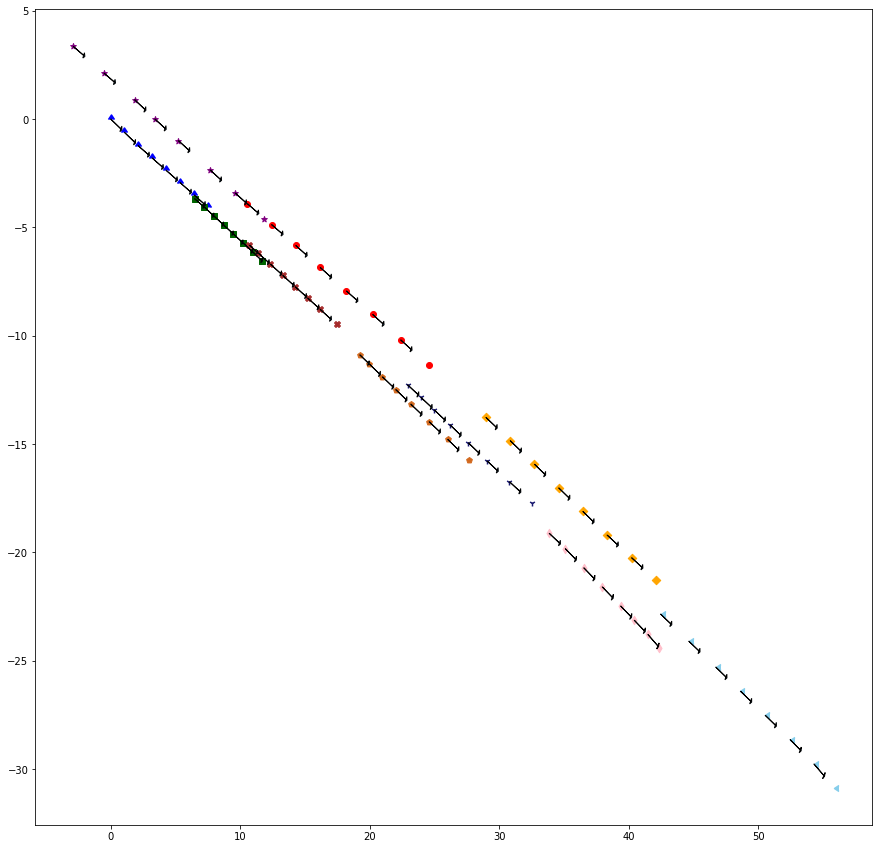

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
plot_multiple_trajs(tar[m], axs)

In [ ]:
tf.transpose(out, [0, 2, 1, 3])[m, 0]

<tf.Tensor: shape=(8, 2), dtype=float32, numpy=
array([[ 0.16314337, -0.31933418],
       [ 0.15917733, -0.22003624],
       [ 0.16289362, -0.31896484],
       [ 0.16269554, -0.3196802 ],
       [ 0.16254549, -0.31973362],
       [ 0.16930872, -0.5610455 ],
       [ 0.16284996, -0.3235481 ],
       [ 0.16354369, -0.3179461 ]], dtype=float32)>

In [ ]:
np.cumsum(tf.transpose(out * tf.constant([[[[std_x, std_y]]]], dtype=tf.float32), [0, 2, 1, 3])[m, 0], axis=0)

array([[  1.1348197,  -1.9270395],
       [  2.242052 ,  -3.2548602],
       [  3.3751347,  -5.179671 ],
       [  4.5068393,  -7.1087985],
       [  5.6375003,  -9.038248 ],
       [  6.815206 , -12.423908 ],
       [  7.9479847, -14.376377 ],
       [  9.085589 , -16.29504  ]], dtype=float32)

In [ ]:
pred = out * tf.constant([[[[std_x, std_y]]]], dtype=tf.float32)

seq_mask_array = 1 - seq_mask
neighbors_mask = 1 - neig_mask

seq_mask_array = seq_mask_array[:, :, np.newaxis, np.newaxis]
neighbors_mask = neighbors_mask[:, :, :, np.newaxis]

pred_masked = pred * seq_mask_array
pred_masked = pred_masked * neighbors_mask

pred = transform_deltas_to_traj(pred_masked[m], tar[m, 0, :, :2])

In [ ]:
np.transpose(pred, [1, 0, 2])

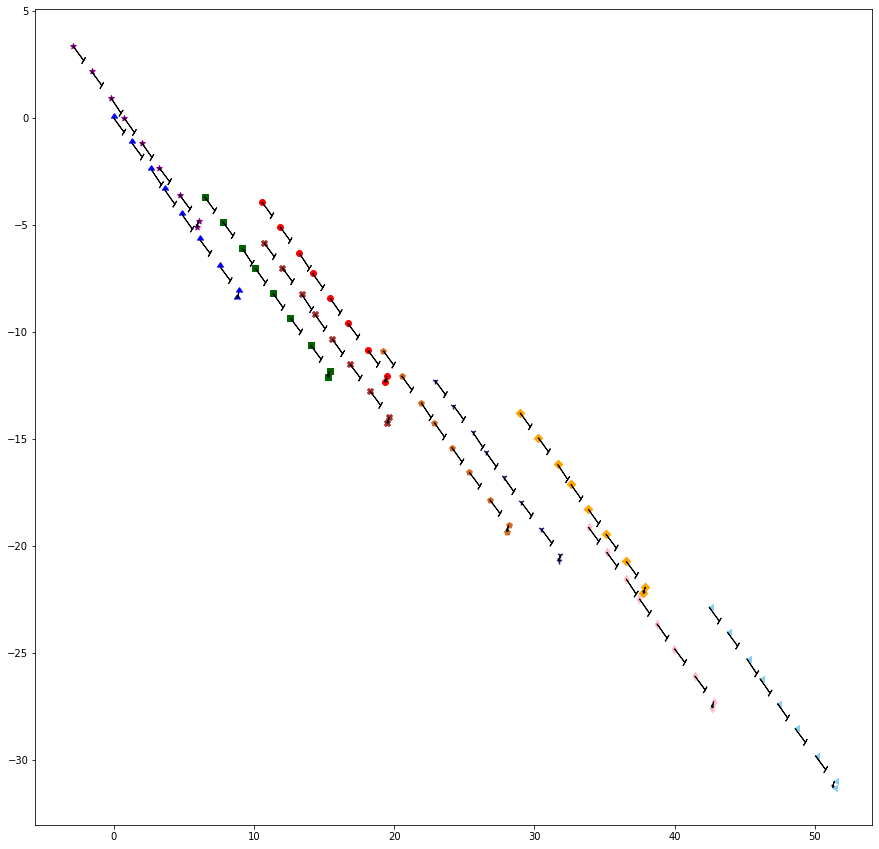

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
plot_multiple_trajs(pred, axs)

In [ ]:
neigh_mask = 1-neig_mask
pred = out[0] * neigh_mask[0][:, :, np.newaxis]

In [ ]:
tar_t = tf.transpose(tar[0,:,:, :3], [1, 0, 2])[:, :, :2]
pred_t = tf.transpose(pred, [1,0,2])[:, :, :2]

In [ ]:
ADE(tar_t.numpy(), pred_t.numpy())

10.687851

# Testing functions

In [ ]:
for i in range(len(cubes)):
  for j in range(len(cubes[i][0])):
    for k in range(len(cubes[i][0][j])):
      for l in range(len(cubes[i][0][j][k])):
        if np.isnan(cubes[i][0][j][k][l]):
          cubes[i][0][j][k][l] = 0.0      


In [ ]:
all_inps = [x[3] for x in cubes]
for inp in all_inps:
  for face in inp:
    for row in face:
      for el in row:
        if np.isnan(el):
          print('WHAAAAT')